In [1]:
%pylab inline
import tensorflow as tf
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
from flowpm.tfpower import linear_matter_power
from flowpm.tfbackground import cosmo,transverse_comoving_distance,a_of_chi,Omega_m_a,rad_comoving_distance
import flowpm.constants as constants
# You may need to adapt this path depending on where you are running the notebook
#This is the power spectrum of initial conditions
klin = np.loadtxt('/Users/dl264294/Desktop/github/flowpm/flowpm/data/Planck15_a1p00.txt').T[0]
plin=linear_matter_power(cosmo, klin)
ipklin = iuspline(klin, plin)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def z2a(z):
    """ converts from redshift to scale factor """
    return 1.0 / (1.0 + z)

In [3]:
transverse_comoving_distance(cosmo,z2a(0.8))*180/np.pi

<tf.Tensor: shape=(), dtype=float32, numpy=111381.78>

In [4]:
# ok, so we want let's say lens planes of size 200 Mpc/h
r = np.linspace(0, 2000,10, endpoint=True)
a = a_of_chi(cosmo, r)

In [5]:
def a2z(a):
    """ converts from scale factor to  redshift """
    return 1.0 / a - 1.0

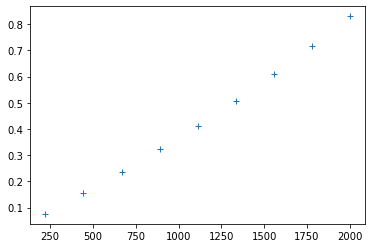

In [6]:
# This allows us to go to roughly z=1
plot(r,a2z(a), '+')

In [7]:
import flowpm                                     

# We will first run the simulation to the lowest scaler factor entering the lightcone
init_stages = np.linspace(0.1, a[-1], 4, endpoint=True)
initial_conditions = flowpm.linear_field([64,64,640],    # size of the cube
                                        [200,200,2000], # Physical size of the cube
                                         ipklin,         # Initial powerspectrum
                                         batch_size=1)
# Sample particles
state = flowpm.lpt_init(initial_conditions, 0.1)   
# Evolve particles down to z=0
med_state = flowpm.nbody(state, init_stages, [64,64,640])         
# Retrieve final density field
med_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), med_state[0])


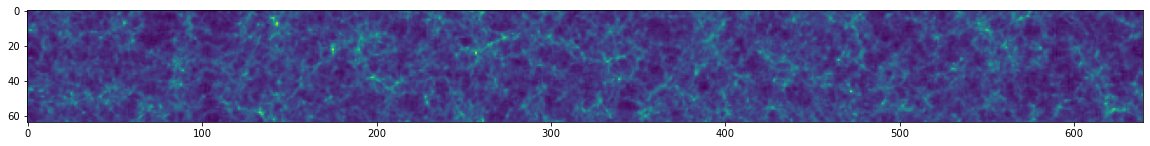

In [8]:
# At this stage we are at the right edge of the lightcone
figure(figsize=[20,5])
imshow(tf.reshape(med_field, [64,64,640]).numpy().sum(axis=0))

In [9]:
# Sweet, now we can run the lightcone, we assume that the timesteps are equally spaced
# in radial comoving distance

In [10]:
from flowpm.tfpm import kick, drift, force

def lightcone(state, stages, nc,
              plane_resolution, # in arcmin
              plane_size, # in pixels
              cosmology=cosmo, pm_nc_factor=1, 
              name="NBody"):
  """
  Integrate the evolution of the state across the givent stages

  Parameters:
  -----------
  state: tensor (3, batch_size, npart, 3)
    Input state

  stages: array
    Array of scale factors, also define slices in the volume

  nc: int
    Number of cells

  pm_nc_factor: int
    Upsampling factor for computing

  Returns
  -------
  state: tensor (3, batch_size, npart, 3)
    Integrated state to final condition
  """
  with tf.name_scope(name):
    state = tf.convert_to_tensor(state, name="state")

    shape = state.get_shape()
    batch_size = shape[1]

    # Unrolling leapfrog integration to make tf Autograph happy
    if len(stages) == 0:
      return state

    ai = stages[0]

    # first force calculation for jump starting
    state = force(state, nc, pm_nc_factor=pm_nc_factor, cosmology=cosmology)

    # Compute the width of the lens planes based on number of time steps
    w = nc[2]//(len(stages)-1)
    nx = nc[0]
    nz = nc[2]
    
    lps = []
    lps_a = []
    
    x, p, f = ai, ai, ai
    # Loop through the stages
    for i in range(len(stages) - 1):
        a0 = stages[i]
        a1 = stages[i + 1]
        ah = (a0 * a1) ** 0.5

        # Kick step
        state = kick(state, p, f, ah, cosmology=cosmology)
        p = ah

        # Drift step
        state = drift(state, x, p, a1, cosmology=cosmology)
        x = a1

        # Access the positions of the particles
        pos = state[0]
        d = pos[:,:,2]
        
        # This is the transverse comoving distance inside the box
        xy = pos[:,:,:2] - nx/2
        
        # Compute density plane in sky coordinates around the center of the lightcone
        # TODO: Confirm conversion from comoving distances to angular size! I thought
        # we should be using the angular diameter distance, but as far as I can see
        # everyone uses the transverse comoving distance, and I don't understand exactly why
        lens_plane = tf.zeros([batch_size, plane_size, plane_size])
        
        # Convert coordinates to angular coords, and then into plane coords
        xy = (xy / tf.expand_dims(d,-1))/np.pi*180*60/plane_resolution
        xy = xy + plane_size/2
        
        # Selecting only the particles contributing to the lens plane
        mask = tf.where((d>(nz - (i+1)*w)) & (d <= (nz - i*w)),1.,0.)
        # And falling inside the plane, NOTE: This is only necessary on CPU, on GPU
        # cic paint 2d can be made to work with non periodic conditions.
        mask = mask * tf.where((xy[...,0]>0) & (xy[...,0]<plane_size),1.,0.)
        mask = mask * tf.where((xy[...,1]>0) & (xy[...,1]<plane_size),1.,0.)
        
        # Compute lens planes by projecting particles
        lens_plane = flowpm.utils.cic_paint_2d(lens_plane, xy + plane_size/2 ,mask)
        lps.append(lens_plane)
        lps_a.append(ah)
        
        # Here we could trim the state vector for particles originally beyond the current lens plane
        # This way the simulation becomes smaller as it runs and we save resources
        state = tf.reshape(state, [3,batch_size, nc[0], nc[1],-1, 3])
        state = state[:,:,:,:,:(nz - i*w - w // 2),:] # We keep w/2 to be safe, so we allow particle to travel
                                                     # A max distance of width/2
        # redefine shape of state
        nc = state.get_shape()[2:5]
        state = tf.reshape(state, [3,batch_size,-1,3])
        # So this seems to work, but we should be a tiny bit careful because we break periodicity in the z
        # direction at z=0.... probably not a big deal but still gotta check what that does.
        
        
        # Force
        state = force(state, nc, pm_nc_factor=pm_nc_factor, cosmology=cosmology)
        f = a1

        # Kick again
        state = kick(state, p, f, a1, cosmology=cosmology)
        p = a1

    return state, lps_a, lps

In [11]:
5.*60/64 # What pixel resolution do we need to cover the 5 tansverse degrees with 128 pixel images

4.6875

In [45]:
#final_state, lps_a, lps = lightcone(med_state, a[::-1], 
  #                                  [64, 64, 640], 
 #                                   5.*60/64, 64)

In [79]:
a_scale=a[::-1]

In [47]:
final_state, lps_a, lps = lightcone(med_state, a_scale[:-1], 
                                    [64, 64, 640], 
                                    5.*60/64, 64)

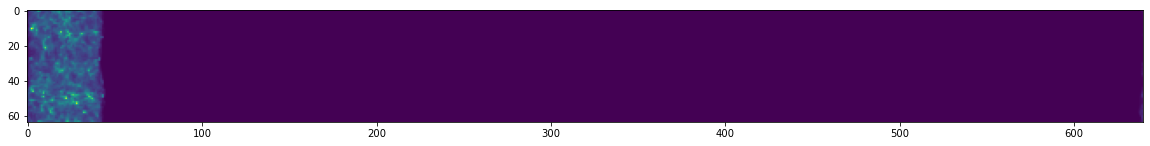

In [48]:
# Retrieve final density field
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])

# And this is what remains of the simulation at redhift=0 
figure(figsize=[20,5])
imshow(tf.reshape(final_field, [64,64,-1]).numpy().sum(axis=0))

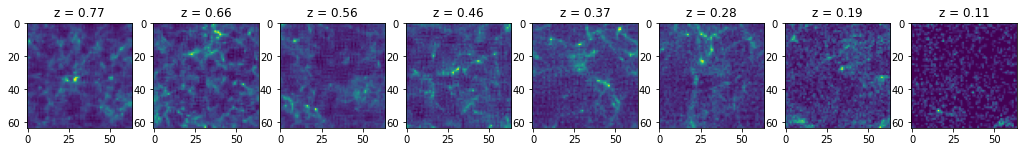

In [50]:
# Here are the lens planes exported during the simulation
figure(figsize=(20,5))
for i in range(8):
    subplot(1,9,i+1)
    imshow(lps[i][0]);
    title('z = %0.2f'%a2z(lps_a[i]))


In [51]:
final_state.shape

TensorShape([3, 1, 163840, 3])

In [52]:
def cons(cosmo,a):
    return 3*(cosmo['H0']**2)*Omega_m_a(cosmo,a)/2*constants.c**2

In [53]:
def W(a,a_s):
    return 1-rad_comoving_distance(cosmo,a)/rad_comoving_distance(cosmo,a_s)

In [54]:
def Delta(a,a_s):
    return rad_comoving_distance(cosmo,a)-rad_comoving_distance(cosmo,a_s)

In [58]:
current_convergence=0
for i in range(8):
        current_convergence += cons(cosmo,lps_a[i])*(lps[i][0] * W(lps_a[i+1],lps_a[i])*Delta(lps_a[i],lps_a[i+1])*rad_comoving_distance(cosmo,lps_a[i])/lps_a[i])
   

KeyboardInterrupt: 

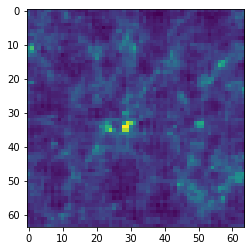

In [57]:
imshow(current_convergence)